# Part 2: Line segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/data"

Mounted at /content/drive


## Import Library and Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile

import re
import cv2

from heapq import heappush, heappop
from PIL import Image

In [3]:
zip_file_name = 'drive/MyDrive/colab/paragraph_images.zip'
base_path = "extracted_files/"
paragraphe_list = []

In [4]:
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files/')

In [5]:
folder_path = base_path

def extract_index_and_i(filename):
    pattern = r'image_(\d+)_bb_(\d+)\.png'  # Define the regex pattern
    match = re.match(pattern, filename)

    if match:
        index = match.group(1)
        i = match.group(2)
        return int(index), int(i)

    return None, None  # Return None if no match is found

# Check if the folder exists
if os.path.exists(base_path):
    for root, directories, files in os.walk(base_path):
        for file in files:
          index, i = extract_index_and_i(file)
          file_path = os.path.join(root, file)

          while len(paragraphe_list) <= index:
                    paragraphe_list.append([])

          while len(paragraphe_list[index]) < i:
                    paragraphe_list[index].append(None)

          paragraphe_list[index][i - 1] = file_path


else:
    print(f"The folder '{folder_path}' does not exist.")

In [6]:
len(paragraphe_list)

10

In [7]:
# Display the paragraph_list
for index, paragraph in enumerate(paragraphe_list):
    print(f"Index {index}: {paragraph}")

Index 0: ['extracted_files/image_0_bb_1.png', 'extracted_files/image_0_bb_2.png']
Index 1: ['extracted_files/image_1_bb_1.png', 'extracted_files/image_1_bb_2.png']
Index 2: ['extracted_files/image_2_bb_1.png', 'extracted_files/image_2_bb_2.png']
Index 3: ['extracted_files/image_3_bb_1.png', 'extracted_files/image_3_bb_2.png']
Index 4: ['extracted_files/image_4_bb_1.png', 'extracted_files/image_4_bb_2.png']
Index 5: ['extracted_files/image_5_bb_1.png', 'extracted_files/image_5_bb_2.png']
Index 6: ['extracted_files/image_6_bb_1.png', 'extracted_files/image_6_bb_2.png']
Index 7: ['extracted_files/image_7_bb_1.png', 'extracted_files/image_7_bb_2.png']
Index 8: ['extracted_files/image_8_bb_1.png', 'extracted_files/image_8_bb_2.png']
Index 9: ['extracted_files/image_9_bb_1.png', 'extracted_files/image_9_bb_2.png']


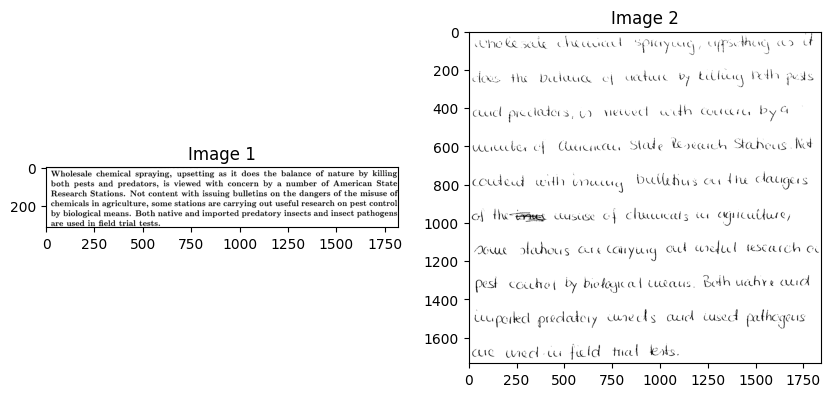

In [8]:
# Load the grayscale image
image1 = cv2.imread(paragraphe_list[0][0], cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(paragraphe_list[0][1], cv2.IMREAD_GRAYSCALE)

# Display the original and binary images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Image 2')

plt.show()

In [9]:
image2 = cv2.imread(paragraphe_list[0][0], cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(image2, 128, 255, cv2.THRESH_BINARY)

In [10]:
binary_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [11]:
binary_images = []

# Iterate through each item in paragraphe_list
for paragraph_info in paragraphe_list:
    image_path = paragraph_info[0]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    binary_images.append(binary)

## Processing

### Horizontal Projection Profile (HPP) Calculation:
Compute HPP: Calculate the Horizontal Projection Profile by summing the pixel values along each row of the binarized image.

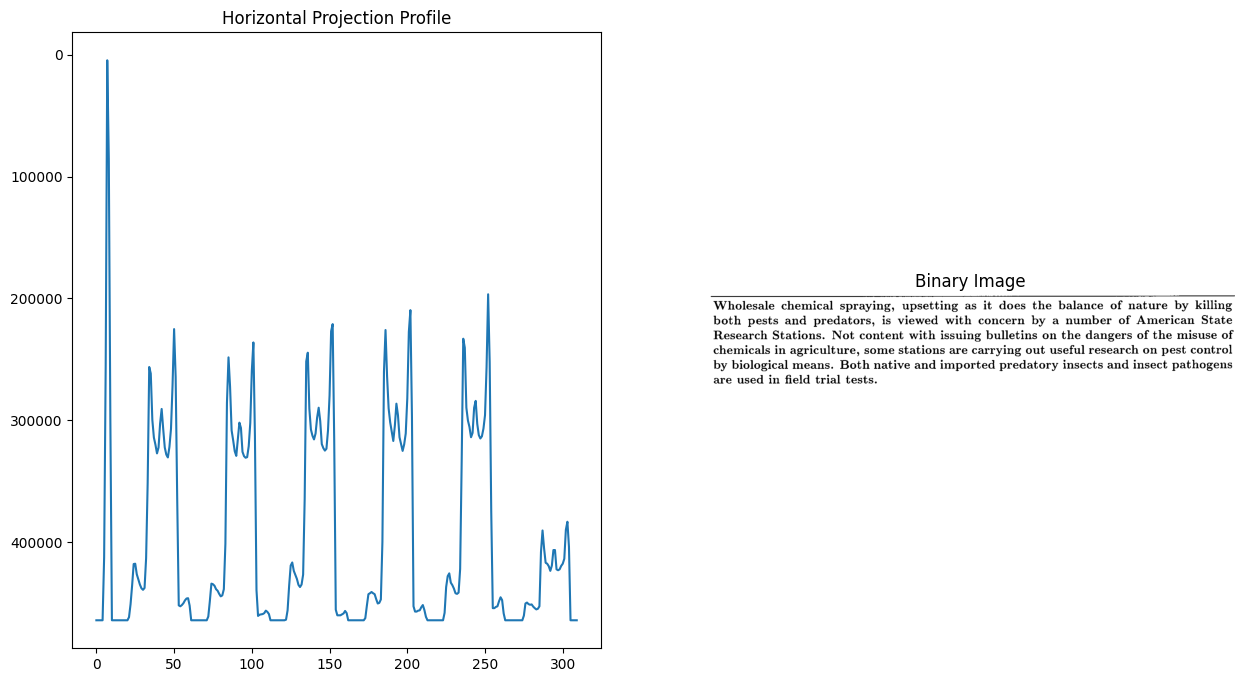

In [12]:
def horizontal_projections(binary_image):
    return np.sum(binary_image, axis=1)

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_image)

# Plotting both images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)


# Display binarized image
ax2.axis("off")
ax2.set_title("Binary Image")
ax2.imshow(binary_image, cmap="gray")

plt.show()

## Identify Peaks:
Find peaks or regions with higher values in the HPP, indicating potential line separations.

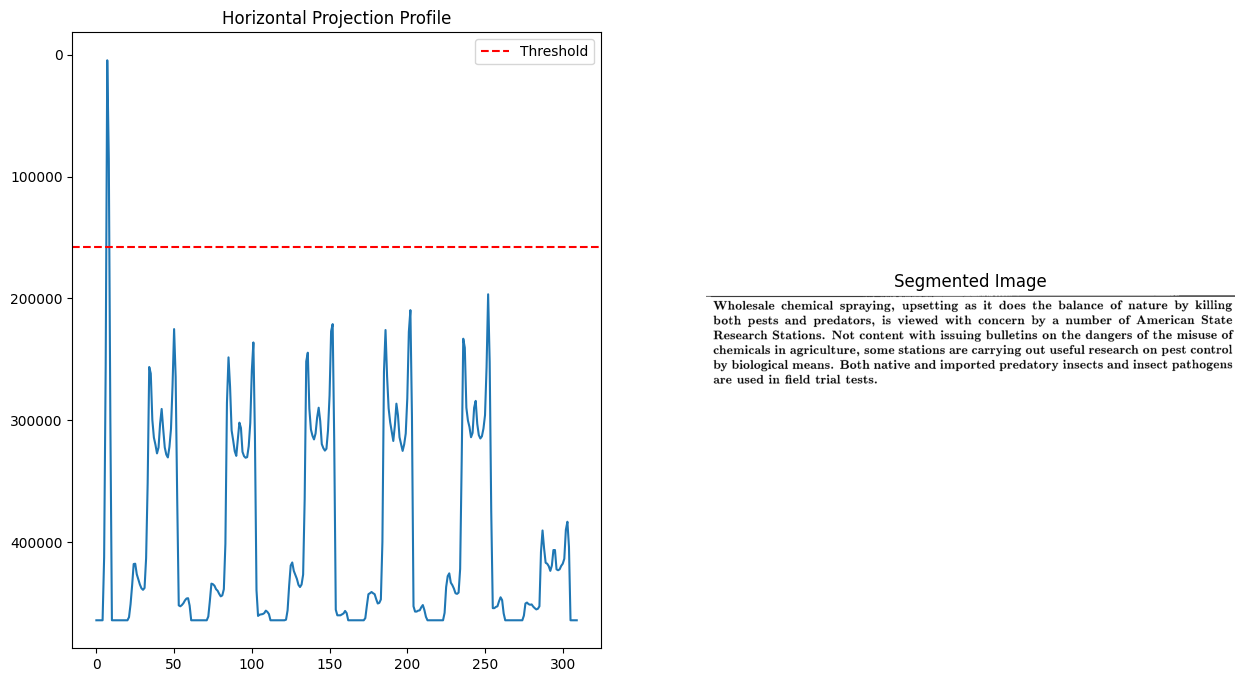

In [16]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_image)
threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 1.5)

peaks = find_peak_regions(hpp, threshold)
peaks_indexes = np.array(peaks)[:, 0].astype(int)

# Create segmented image based on identified peaks
segmented_img = np.copy(binary_image)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

# Plotting the original binary image with segmented regions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line
ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)
ax1.legend()  # Show legend

# Display the segmented image
ax2.axis("off")
ax2.set_title("Segmented Image")
ax2.imshow(segmented_img, cmap="gray")

plt.show()

In [17]:
# Group the peaks for path planning
diff_between_consec_numbers = np.diff(peaks_indexes)
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
peak_groups = [item for item in peak_groups if len(item) > 10]

print("Peak groups found:", len(peak_groups))

Peak groups found: 0


## Problem

I have encountered 2 problems:
- The short line is not detected
- The paragraph is not correctly segmented

### Bad segmentation

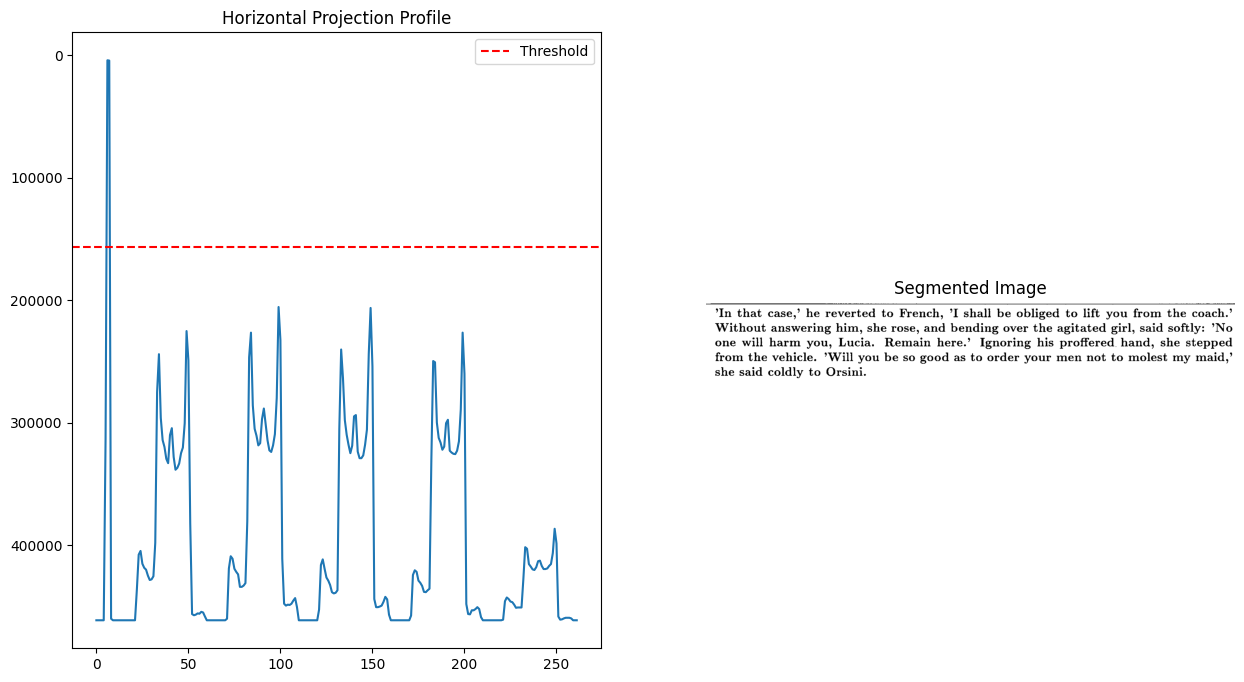

In [86]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_images[1])
threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 1.5)

peaks = find_peak_regions(hpp, threshold)
peaks_indexes = np.array(peaks)[:, 0].astype(int)

# Create segmented image based on identified peaks
segmented_img = np.copy(binary_images[1])
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

# Plotting the original binary image with segmented regions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line
ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)
ax1.legend()  # Show legend

# Display the segmented image
ax2.axis("off")
ax2.set_title("Segmented Image")
ax2.imshow(segmented_img, cmap="gray")

plt.show()

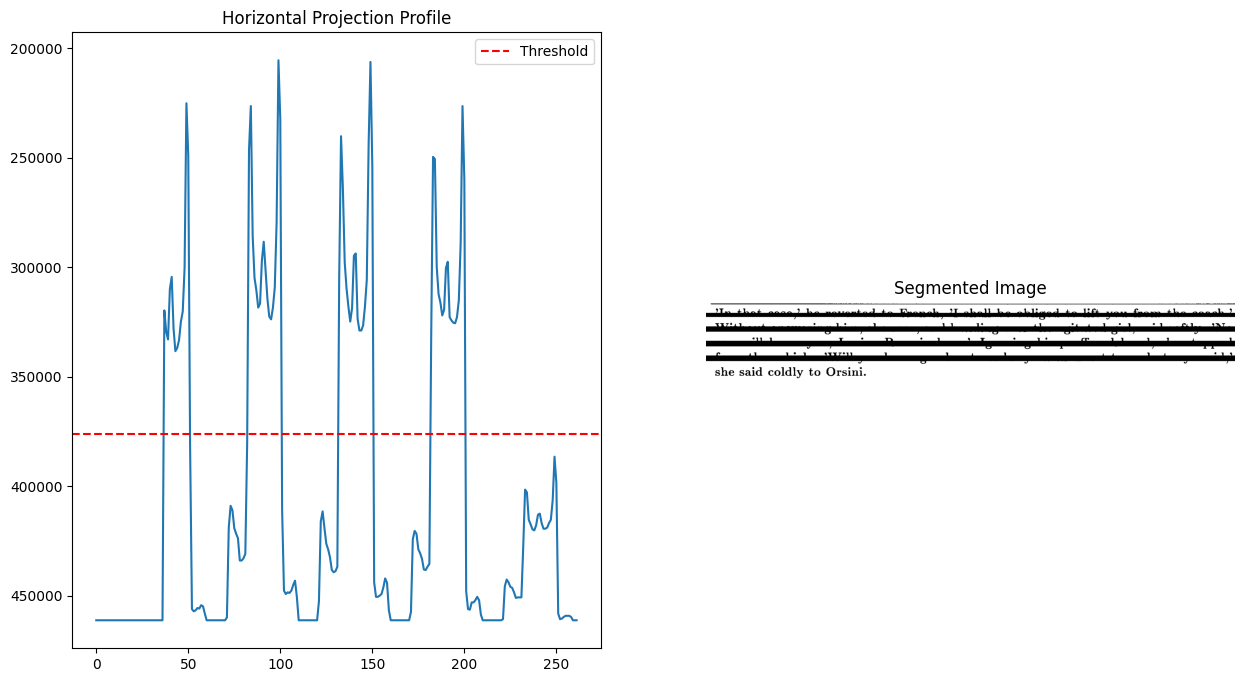

In [83]:
if len(peaks_indexes) < 10:
    # Find the peak closest to the middle of the image
    middle_peak_index = int(len(hpp) / 2)
    closest_peak_index = min(peaks_indexes, key=lambda x: abs(x - middle_peak_index))

    # Define the range to remove around the identified peak
    removal_range = 30  # Adjust this value as needed to cover the entire peak region

    # Remove the entire peak region
    removal_start = max(0, closest_peak_index - removal_range)
    removal_end = min(len(hpp), closest_peak_index + removal_range)

    segmented_img[removal_start:removal_end, :] = 255  # Set to white

    # Recalculate HPP and threshold after removing the portion
    hpp = horizontal_projections(segmented_img)
    threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

    # Find peaks again after removing the portion
    peaks = find_peak_regions(hpp, threshold)
    peaks_indexes = np.array(peaks)[:, 0].astype(int)

    # Create segmented image based on identified peaks after removal
    segmented_img = np.copy(binary_images[1])
    r, c = segmented_img.shape
    for ri in range(r):
        if ri in peaks_indexes:
            segmented_img[ri, :] = 0

    # Plotting the original binary image with segmented regions
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

    # Plot horizontal projection profile
    ax1.set_title("Horizontal Projection Profile")
    ax1.plot(hpp)
    ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line
    ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)
    ax1.legend()  # Show legend

    # Display the segmented image
    ax2.axis("off")
    ax2.set_title("Segmented Image")
    ax2.imshow(segmented_img, cmap="gray")

    plt.show()

In [85]:
# Group the peaks for path planning
diff_between_consec_numbers = np.diff(peaks_indexes)
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
peak_groups = [item for item in peak_groups if len(item) > 5]

print("Peak groups found:", len(peak_groups))

Peak groups found: 4


### Short line


In [47]:
def calculate_peak_lengths_and_spaces(peak_groups):
    peak_lengths = []
    peak_spaces = []

    for group_idx in range(len(peak_groups) - 1):
        current_group = peak_groups[group_idx]
        next_group = peak_groups[group_idx + 1]

        if len(current_group) >= 2 and len(next_group) >= 2:
            space = next_group[1] - current_group[-1]
            peak_spaces.append(space)
            peak_lengths.append(len(current_group))

    return peak_lengths, peak_spaces

In [48]:
peak_lengths, peak_spaces = calculate_peak_lengths_and_spaces(peak_groups)

mean_peak_space = np.mean(peak_spaces)
mean_peak_length = np.mean(peak_lengths)

# Calculate the last peak index
last_peak_index = peak_groups[-1][-1]
predicted_last_peak_index = last_peak_index + int(round(mean_peak_space))
predicted_new_peak_length = int(round(mean_peak_length))

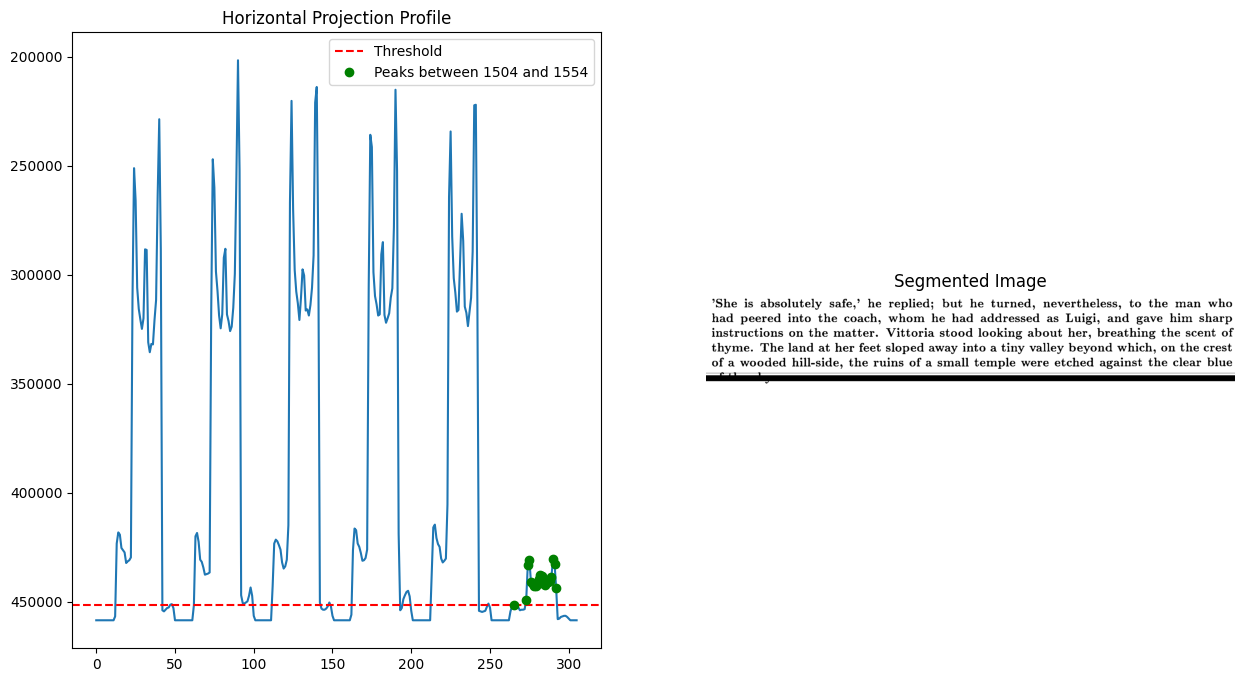

In [53]:
# Function to find peaks within a specified range
def find_peaks_within_range(hpp, start_idx, end_idx, threshold):
    peaks_within_range = []
    for i in range(start_idx, end_idx):
        if hpp[i] < threshold:
            peaks_within_range.append([i, hpp[i]])
    return peaks_within_range

# Calculate Horizontal Projection Profile (HPP)
hpp = horizontal_projections(binary_image)
threshold = np.max(hpp) - 7000

# Display all peaks within the specified range
start_index = predicted_last_peak_index + predicted_new_peak_length
if (start_index + predicted_new_peak_length) > binary_image.shape[0]:
  end_index = predicted_last_peak_index + predicted_new_peak_length
else:
    end_index = binary_image.shape[0] - 1

peaks_within_range = find_peaks_within_range(hpp, start_index, end_index, threshold)
peaks_indexes_within_range = np.array(peaks_within_range)[:, 0].astype(int)

# Create segmented image based on identified peaks
segmented_img = np.copy(binary_image)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes_within_range:
        segmented_img[ri, :] = 0

# Plotting the original binary image with segmented regions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Plot horizontal projection profile
ax1.set_title("Horizontal Projection Profile")
ax1.plot(hpp)
ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')  # Plot threshold line


ax1.plot(peaks_indexes_within_range, np.array(peaks_within_range)[:, 1], 'go', label='Peaks between 1504 and 1554')  # Plot identified peaks
ax1.legend()  # Show legend

ax1.invert_yaxis()  # Invert y-axis for the first image (HPP)

# Display the segmented image
ax2.axis("off")
ax2.set_title("Segmented Image")
ax2.imshow(segmented_img, cmap="gray")

plt.show()

In [87]:
# Group the peaks for path planning
diff_between_consec_numbers = np.diff(peaks_indexes_within_range)
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
new_peak_groups = np.split(peaks_indexes_within_range, indexes_with_larger_diff)
new_peak_groups = [item for item in new_peak_groups if len(item) > 10]

print("Peak groups found:", len(new_peak_groups))

Peak groups found: 1


In [55]:
peak_groups.append(new_peak_groups[0])

In [56]:
print("Updated Peak Groups:")
for idx, group in enumerate(peak_groups):
    print(f"Group {idx + 1}: {group}")

Updated Peak Groups:
Group 1: [37 38 39 40 41 42 43 44 45 46 47 48 49]
Group 2: [50 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Group 3: [100 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149]
Group 4: [150 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]
Group 5: [265 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292]


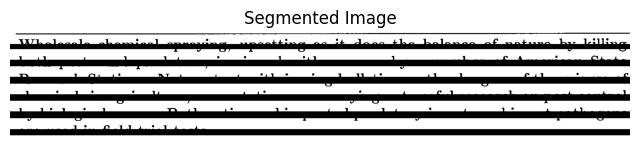

In [29]:
# Create segmented image based on identified peak groups
segmented_img = np.copy(binary_image)
r, c = segmented_img.shape

for group in peak_groups:
    for ri in group:
        if ri < r:
            segmented_img[ri, :] = 0

# Display the segmented image
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Segmented Image")
plt.imshow(segmented_img, cmap="gray")
plt.show()

## A* algorithm

In [59]:
# Loop through each peak group
for i in range(len(peak_groups) - 1):
    y_start = int(((peak_groups[i][1] + peak_groups[i][-1]) / 2 + (peak_groups[i + 1][1] + peak_groups[i + 1][-1]) / 2) / 2)
    y_end = y_start  # Same y-coordinate for the end point

    roi_start_x = 0
    roi_end_x = binary_image.shape[1] - 1
    roi_start_y = peak_groups[i][-1]
    roi_end_y = peak_groups[i + 1][1]

    roi_img = binary_image[roi_start_y:roi_end_y, roi_start_x:roi_end_x]
    print(roi_img.shape)
    # Visualize the roi_img with start and end points
    plt.figure(figsize=(6, 6))
    plt.imshow(roi_img, cmap='gray')
    plt.title('Region of Interest (ROI) Image with Start/End Points')

    # Plot start point on the roi_img
    plt.plot(0, y_start - roi_start_y, 'go', markersize=8, label='Start Point')  # Green 'go' marker

    # Plot end point on the roi_img
    plt.plot(roi_end_x - roi_start_x, y_end - roi_start_y, 'ro', markersize=8, label='End Point')  # Red 'ro' marker

    plt.axis('off')
    plt.show()

    start = (roi_start_x, y_start)
    end = (roi_end_x, y_end)

In [60]:
# Define a function to calculate the Manhattan distance as the heuristic
def heuristic(a, b):
    return abs(b[0] - a[0]) + abs(b[1] - a[1])

# A* algorithm implementation
def astar(grid, start, end):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    open_set = []
    heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, end)}

    while open_set:
        current = heappop(open_set)[1]

        if current == end:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 0:  # Check for obstacles (0)
                    continue

                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, end)
                    heappush(open_set, (f_score[neighbor], neighbor))

    return []

## Generalization

In [98]:
general_folder_name = "segmented_line"
# Assuming binary_images is a list of binary images
for i, binary_image in enumerate(binary_images):
    # Perform processing steps for each binary image
    hpp = horizontal_projections(binary_image)
    threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 1.5)

    peaks = find_peak_regions(hpp, threshold)
    peaks_indexes = np.array(peaks)[:, 0].astype(int)

    diff_between_consec_numbers = np.diff(peaks_indexes)
    indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
    peak_groups = [item for item in peak_groups if len(item) > 10]


    if len(peaks_indexes) < 10:
      # Find the peak closest to the middle of the image
      middle_peak_index = int(len(hpp) / 2)
      closest_peak_index = min(peaks_indexes, key=lambda x: abs(x - middle_peak_index))

      # Define the range to remove around the identified peak
      removal_range = 30

      # Remove the entire peak region
      removal_start = max(0, closest_peak_index - removal_range)
      removal_end = min(len(hpp), closest_peak_index + removal_range)

      segmented_img[removal_start:removal_end, :] = 255  # Set to white

      # Recalculate HPP and threshold after removing the portion
      hpp = horizontal_projections(segmented_img)
      threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

      # Find peaks again after removing the portion
      peaks = find_peak_regions(hpp, threshold)
      peaks_indexes = np.array(peaks)[:, 0].astype(int)

    else:

      hpp = horizontal_projections(binary_image)
      threshold = np.max(hpp) - ((np.max(hpp) - np.min(hpp)) / 3)

      # Find peaks again after removing the portion
      peaks = find_peak_regions(hpp, threshold)
      peaks_indexes = np.array(peaks)[:, 0].astype(int)

    diff_between_consec_numbers = np.diff(peaks_indexes)
    indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
    peak_groups = [item for item in peak_groups if len(item) > 5]

    peak_lengths, peak_spaces = calculate_peak_lengths_and_spaces(peak_groups)

    mean_peak_space = np.mean(peak_spaces)
    mean_peak_length = np.mean(peak_lengths)

    # Calculate the last peak index
    last_peak_index = peak_groups[-1][-1]
    predicted_last_peak_index = last_peak_index + int(round(mean_peak_space))
    predicted_new_peak_length = int(round(mean_peak_length))


    if (predicted_last_peak_index + predicted_new_peak_length + 10 < binary_image.shape[0]):
      # Calculate Horizontal Projection Profile (HPP)
      hpp = horizontal_projections(binary_image)
      threshold = np.max(hpp) - 7000

      # Display all peaks within the specified range
      start_index = predicted_last_peak_index + predicted_new_peak_length + 10
      if (start_index + predicted_new_peak_length) > binary_image.shape[0]:
        end_index = predicted_last_peak_index + predicted_new_peak_length
      else:
          end_index = binary_image.shape[0] - 1

      peaks_within_range = find_peaks_within_range(hpp, start_index, end_index, threshold)

      if peaks_within_range:
          peaks_indexes_within_range = np.array(peaks_within_range)[:, 0].astype(int)

          diff_between_consec_numbers = np.diff(peaks_indexes_within_range)
          indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
          new_peak_groups = np.split(peaks_indexes_within_range, indexes_with_larger_diff)
          new_peak_groups = [item for item in new_peak_groups if len(item) > 10]

          peak_groups.append(new_peak_groups[0])

    # List to store all paths
    all_paths = []

    # Create folder for segmented images of this binary image
    folder_name = f"segmented_images_{i}"
    folder_name = general_folder_name + "/" + folder_name #test
    os.makedirs(folder_name, exist_ok=True)

    # Loop through each peak group
    for i in range(len(peak_groups) - 1):
        y_start = int(((peak_groups[i][1] + peak_groups[i][-1]) / 2 + (peak_groups[i + 1][1] + peak_groups[i + 1][-1]) / 2) / 2)
        y_end = y_start  # Same y-coordinate for the end point

        start = (y_start, 0)
        end = (y_end, binary_image.shape[1] - 1)

        # Run A* algorithm on the region of interest
        path = astar(binary_image, start, end)

        # Collect paths to plot later
        if path:
            path = np.array(path)[:, ::-1]  # Reversing the path to match the (x, y) format for plotting

            # Append the path to the list of all paths
            all_paths.append(path)

    if all_paths:
        for i, path in enumerate(all_paths):
            if i == 0:
                # Crop the region between the top and the first path generated by A*
                extracted_region = binary_image[:path[0, 1], :]
            else:
                # Crop the region between consecutive paths
                prev_path = all_paths[i - 1]
                extracted_region = binary_image[prev_path[0, 1]:path[0, 1], :]

            # Normalize the intensity values between 0 and 255
            extracted_region_normalized = ((extracted_region - extracted_region.min()) / (extracted_region.max() - extracted_region.min()) * 255).astype(np.uint8)

            # Save the extracted region as an image in the folder
            extracted_image = Image.fromarray(extracted_region_normalized)
            extracted_image.save(os.path.join(folder_name, f'extracted_region_{i + 1}.png'))

        # Extract the region between the last path and the bottom of the image
        last_path = all_paths[-1]
        extracted_region = binary_image[last_path[-1, 1]:, :]

        # Normalize the intensity values between 0 and 255
        extracted_region_normalized = ((extracted_region - extracted_region.min()) / (extracted_region.max() - extracted_region.min()) * 255).astype(np.uint8)

        # Save the extracted region as an image in the folder
        extracted_image = Image.fromarray(extracted_region_normalized)
        extracted_image.save(os.path.join(folder_name, f'extracted_region_{len(all_paths) + 1}.png'))

In [99]:
# Path to the directory you want to compress into a zip file
directory_to_zip = general_folder_name

# Path to save the zip file in your Google Drive
zip_destination = '/content/drive/MyDrive/colab/lines_images_b.zip'

# Create a zip file
with zipfile.ZipFile(zip_destination, 'w') as zipf:
    # Walk through the directory and add files to the zip file
    for foldername, subfolders, filenames in os.walk(directory_to_zip):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

print(f'Zip file created and saved to: {zip_destination}')

Zip file created and saved to: /content/drive/MyDrive/colab/lines_images_b.zip
